# Машинное обучение в бизнесе
# Урок 3. Связь бизнес-показателей и DS-метрик

**Предварительная подготовка**

In [24]:
pip install catboost


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [54]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, log_loss, confusion_matrix
from catboost import CatBoostClassifier


%matplotlib inline

**Функции и классы для заданий**

In [55]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

Функция показа ROC кривой.

In [56]:
def show_roc_curve(y_test, y_pred):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_pred, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()

Функция валидации модели.

In [57]:
rubl_test = 1400
rubl_early_treatment = 15000
rubl_late_treatment = 20000

In [69]:
def validate_model(model, X_train, X_test, y_train, y_test):
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)

    # обучение модели и предсказание
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]

    # поиск оптимальной границы
    beta = 1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_pred)
    f1 = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
    ix = np.argmax(f1)

    # отрисовка кривой roc auc
    show_roc_curve(y_test, y_pred)

    # оценка бизнес метрик
    cnf_matrix = confusion_matrix(y_test, y_pred > thresholds[ix])

    TN = cnf_matrix[0][0]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]

    TPR = TP / (TP+FN)
    FPR = FP / (FP+TN)
    TNR = TN / (FP+TN)

    rubl_without_test = (FN + TP) * rubl_late_treatment
    rubl_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
    rubl_test_all = np.sum(cnf_matrix) * rubl_test + (FN + TP) * rubl_early_treatment

    # Return metrics
    return {'precision': precision[ix],
            'recall': recall[ix],
            'f1_score': f1[ix],
            'roc_auc': roc_auc_score(y_test, y_pred),
            'cv_roc_auc': cv_score,
            'cv_roc_auc_std': cv_score_std,
            'rubl_late_treatment':(FN + TP) * rubl_late_treatment,
            'rubl_test_all':np.sum(cnf_matrix) * rubl_test + (FN + TP) * rubl_early_treatment,
            'rubl_ML':(FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment,
            'rubl_without_test - rubl_ML':rubl_without_test - rubl_ML,
            'rubl_without_test - rubl_test_all':rubl_without_test - rubl_test_all,
            'rubl_test_all - rubl_ML':rubl_test_all - rubl_ML
            }

**Работа с данными**

Читаем данные.

In [59]:
!wget 'https://drive.google.com/uc?export=download&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G' -O train_case2.csv

--2022-05-23 18:49:34--  https://drive.google.com/uc?export=download&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G
Resolving drive.google.com (drive.google.com)... 74.125.203.101, 74.125.203.113, 74.125.203.138, ...
Connecting to drive.google.com (drive.google.com)|74.125.203.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9v63tqit9jg2cfnttqu71uns6kn7n07g/1653331725000/14904333240138417226/*/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G?e=download [following]
--2022-05-23 18:49:35--  https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9v63tqit9jg2cfnttqu71uns6kn7n07g/1653331725000/14904333240138417226/*/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G?e=download
Resolving doc-00-c0-docs.googleusercontent.com (doc-00-c0-docs.googleusercontent.com)... 142.250.157.132, 2404:6800:4008:c13::84
Connecting to doc-00-c0-docs.googleusercontent.com (doc-00-c0-doc

In [60]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Делим датасет.

In [61]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['cardio']), 
                                                    df['cardio'],
                                                    random_state=0)

Пайплайны трансформаций.

In [62]:
continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

# Объединяем пайплайны признаков в один
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)    

## Задание 1, 2, 3

1. Обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта.
2. Вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики).

3. Вывести сравнение полученных моделей по метрикам бизнеса по показателям с урока
стоимость лечения 15000р, если сделали тест и начали лечить вовремя
стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
стоимость теста 1400р

### Решение Заданий 1, 2, 3

Здесь будут храниться результаты сравнения моделей.

In [63]:
final_board_df = pd.DataFrame(columns=['precision', 'recall', 'f1_score', 'roc_auc', 'cv_roc_auc', 'cv_roc_auc_std'])

Логистическая регрессия.

In [64]:
clf_LR = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state=42)),
])

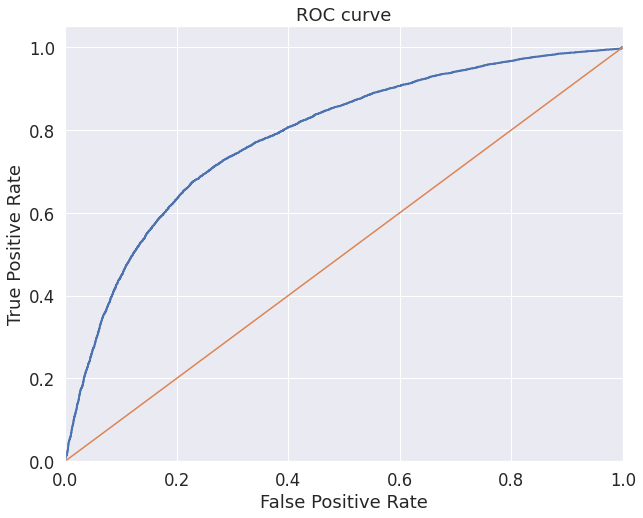

In [70]:
model_metrics = validate_model(clf_LR, X_train, X_test, y_train, y_test)
final_board_df = final_board_df.append(model_metrics, ignore_index=True)

Случайный лес.

In [71]:
clf_RFC = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state=42)),
])

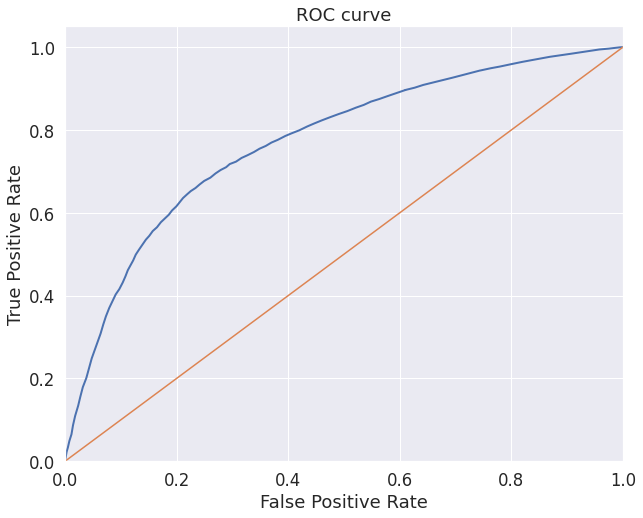

In [72]:
model_metrics = validate_model(clf_RFC, X_train, X_test, y_train, y_test)
final_board_df = final_board_df.append(model_metrics, ignore_index=True)

Градиентный бустинг.

In [73]:
clf_GBC = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(random_state=42)),
])

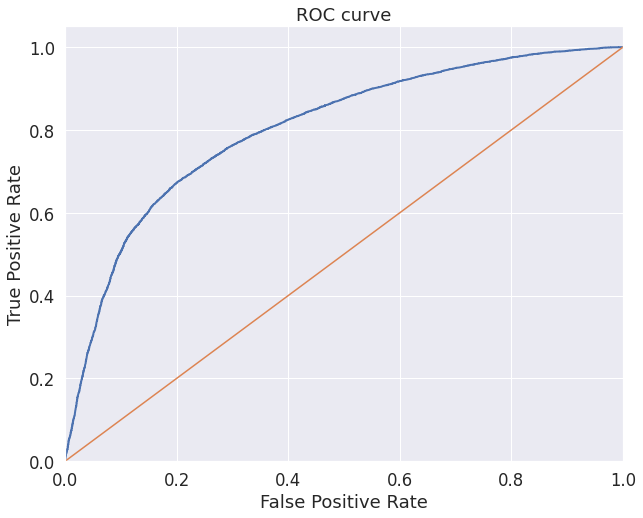

In [74]:
model_metrics = validate_model(clf_GBC, X_train, X_test, y_train, y_test)
final_board_df = final_board_df.append(model_metrics, ignore_index=True)

In [75]:
clf_CBC = Pipeline([
    ('features', feats),
    ('classifier', CatBoostClassifier(random_state=42, verbose=False)),
])

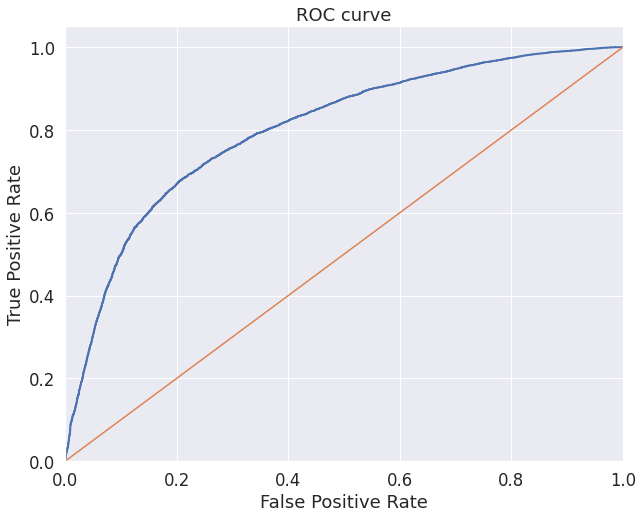

In [76]:
model_metrics = validate_model(clf_CBC, X_train, X_test, y_train, y_test)
final_board_df = final_board_df.append(model_metrics, ignore_index=True)

Метрики.

In [77]:
final_board_df

,precision,recall,f1_score,roc_auc,cv_roc_auc,cv_roc_auc_std,rubl_ML,rubl_late_treatment,rubl_test_all,rubl_test_all - rubl_ML,rubl_without_test - rubl_ML,rubl_without_test - rubl_test_all
0,0.647431,0.837558,0.730323,0.784035,0.786450,0.004705,152974200.0,173600000.0,154700000.0,1725800.0,20625800.0,18900000.0
1,0.642669,0.815553,0.718863,0.771037,0.774612,0.002827,153699400.0,173600000.0,154700000.0,1000600.0,19900600.0,18900000.0
2,0.697848,0.788134,0.740248,0.802615,0.802095,0.003615,153122800.0,173600000.0,154700000.0,1577200.0,20477200.0,18900000.0
3,0.693682,0.791820,0.739509,0.801194,0.801494,0.004335,153109800.0,173600000.0,154700000.0,1590200.0,20490200.0,18900000.0


## Задание 4
Сделать выводы о том, какая модель справилась с задачей лучше других.

### Решение Задания 4




Модель градиентного бустинга справилась лучше остальных по всем метрикам, кроме recall.

Модель логистической регрессии показала себя немного лучше остальных. Поэтому, если метрика recall важна, то лучше использовать Логистическую регрессию.

В остальных слуючаях лучше градиентный бустинг.

Что касается бизнес-показателей, то модель логистической регрессии экономит значительно больше денег в случае "тотального" теста и больше всех, но не так значительно в случае отмены тестирования. Поэтому есть основания считать, что и в промежуточных вариантах тоже выгоднее прислушаться к данным именно этой модели.

## Задание 5*
*Найти порог классификации по деньгам для лучшей модели
Стоимость лечения 15000р, если сделали тест и начали лечить вовремя
Стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
Стоимость теста 1400р

### Решение Задания 5*

In [78]:
def business_threshold_calibrate(y_test, y_score, thresholds,
                                 rubl_test=100, rubl_early_treatment=100, rubl_late_treatment=1000):
    business_threshold = 0
    r_test_all_r_ML_ = 0

    rubl_ML_ = 1_000_000_000 

    rs = []
    n = 20
    for opt_buisness_tr in np.linspace(0, 1, n).tolist():
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_score > (opt_buisness_tr))
        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        rubl_1 = (TP + FN) * rubl_late_treatment
        rubl_test_all = np.sum(cnf_matrix) * rubl_test + (FN + TP) * rubl_early_treatment
        rubl_ML = (TP + FP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
        
        r_test_all_r_ML = rubl_test_all - rubl_ML 
        
        if rubl_ML < rubl_ML_:            
            business_threshold = opt_buisness_tr
            
            rubl_ML_ = rubl_ML
            
        rs.append(rubl_ML)   
            
    
    print('расходы, если не делать тест и ждать симптомов:', rubl_1)
    print('расходы, если делать тест всем и лечить группу больных:', rubl_test_all)
    print('расходы, если использовать МЛ:', rubl_ML_)

    print('Расходы "решение не делать тесты - расходы с МL:"', rubl_1 - rubl_ML_)
    print('Расходы "решение не делать тесты - расходы сделать тесты всем":', rubl_1 - rubl_test_all)
    print('Расходы "сделать тесты всем - решение делать тесты ML":', rubl_test_all - rubl_ML_)
    
    plt.title('Потери при МЛ решении')
    plt.xlabel('Отсечка')
    plt.ylabel('Потери')
    plt.plot(np.linspace(0,1,n), rs)
    plt.show()
    return business_threshold

In [79]:
y_pred = clf_LR.predict_proba(X_test)[:, 1]


In [81]:
precision, recall, thresholds = precision_recall_curve(y_test.values, y_pred)
fscore = 2 * (precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.3869370891147379, F-Score=0.730, Precision=0.647, Recall=0.838


расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу больных: 154700000
расходы, если использовать МЛ: 152712400
Расходы "решение не делать тесты - расходы с МL:" 20887600
Расходы "решение не делать тесты - расходы сделать тесты всем": 18900000
Расходы "сделать тесты всем - решение делать тесты ML": 1987600


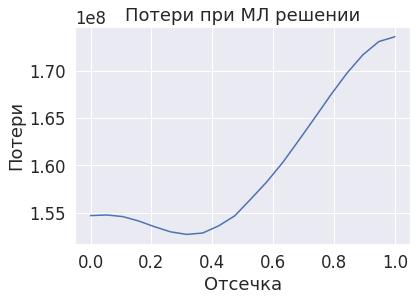


уровень порога по бизнес метрике 0.3157894736842105
уровень порога по f1 метрике 0.3869370891147379


In [83]:
busines_tr = business_threshold_calibrate(y_test, y_pred, 
                                          thresholds[ix],
                                          rubl_test=1400, 
                                          rubl_early_treatment=15000, 
                                          rubl_late_treatment=20000)

print()
print('уровень порога по бизнес метрике', busines_tr)
print('уровень порога по f1 метрике', thresholds[ix])